# Notebook for processing Drifter data from GLAD and LASER experiments

##### This repo has code for converting Carthe drifter data to format easily accessible pkl files.

Original MATLAB code used for Balwada et al (2022) Science Advances paper can be found in https://github.com/dhruvbalwada/SF3_to_KEflux. The code has been translated into Python and parallelize for faster processing.

The 15-min QC drifter data from the two experiments can be accessed here: https://data.gulfresearchinitiative.org/

In [1]:
import matplotlib.pyplot as plt
import importlib

import drifter_analysis_SFs
importlib.reload(drifter_analysis_SFs)
from drifter_analysis_SFs import *

### Convert .dat files into .pkl

##### NOTE: Change the number of max_workers to -1 for using all available cores.

In [2]:
# GLAD
drifter_data_glad = load_glad_trajectories(
    './GLAD_15min_filtered.dat',
    './traj_struct_GLAD_15min_03_May_2021.pkl',
    max_workers=12  # Adjust based on your system
)


Found 297 drifters. Processing...


Processing drifters: 100%|██████████████| 297/297 [00:01<00:00, 290.85it/s]


✅ Saved drifter data to traj_struct_GLAD_15min_03_May_2021.pkl


In [3]:
# LASER
drifter_data_laser = load_laser_trajectories(
    './laser_spot_drifters_clean_v15.dat',
    output_file='./traj_structs_LASER_15min_03_May_2021.pkl',
    max_workers=12
)

Found 956 L-type drifters. Processing...


Processing L-type drifters: 100%|███████| 956/956 [00:07<00:00, 120.71it/s]


Found 3 M-type drifters. Processing...


Processing M-type drifters: 100%|███████████| 3/3 [00:00<00:00, 216.24it/s]


Found 467 U-type drifters. Processing...


Processing U-type drifters: 100%|███████| 467/467 [00:04<00:00, 113.27it/s]


Found 6 V-type drifters. Processing...


Processing V-type drifters: 100%|███████████| 6/6 [00:00<00:00, 339.88it/s]


✅ Saved LASER drifter data to traj_structs_LASER_15min_03_May_2021.pkl


### Converts files into arrays

Processing 297 drifters from GLAD...


Aligning: 100%|████████████████████████| 297/297 [00:00<00:00, 1372.04it/s]


Saved output to ./traj_mat_GLAD_15min_04_May_2021.pkl


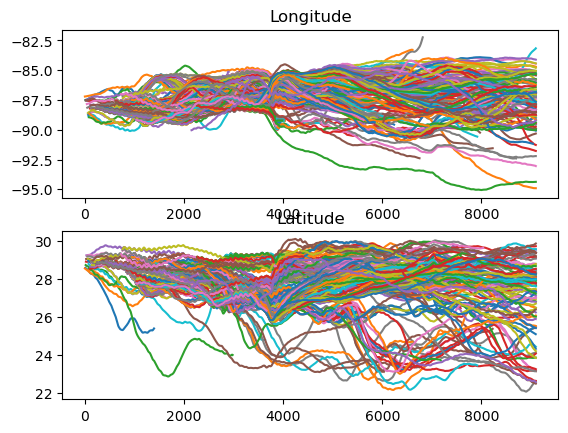

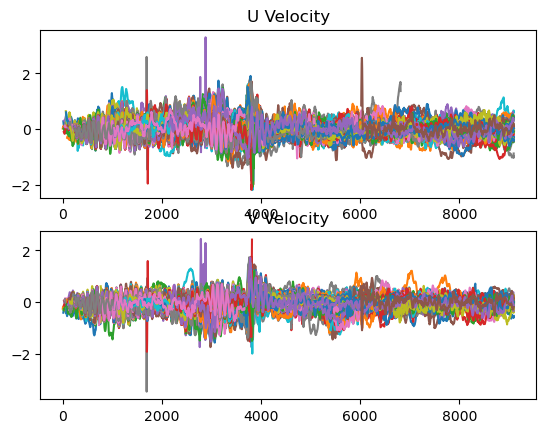

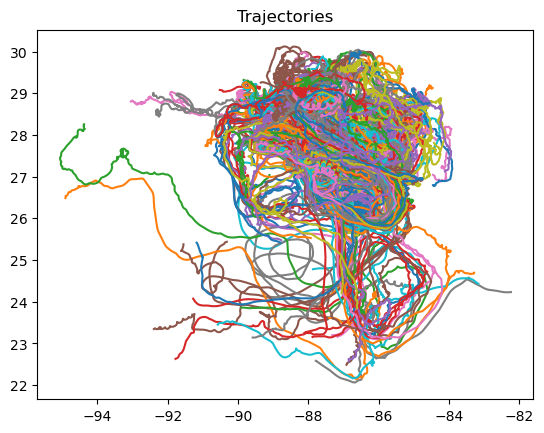

In [4]:
# GLAD
T, X, Y, U, V = convert_drifter_struct_to_array(
    pkl_file_path='./traj_struct_GLAD_15min_03_May_2021.pkl',     # the file created in step 1
    sel_data='GLAD',                     # or 'GLAD' depending on dataset
    output_dir='./',                 # where to save the aligned trajectory data
    make_plots=True,                      # optional plotting
    max_workers=6                       # number of parallel processes
)


Processing 956 drifters from LASER...


Aligning: 100%|█████████████████████████| 956/956 [00:03<00:00, 246.03it/s]


Saved output to ./traj_mat_LASER_15min_04_May_2021.pkl


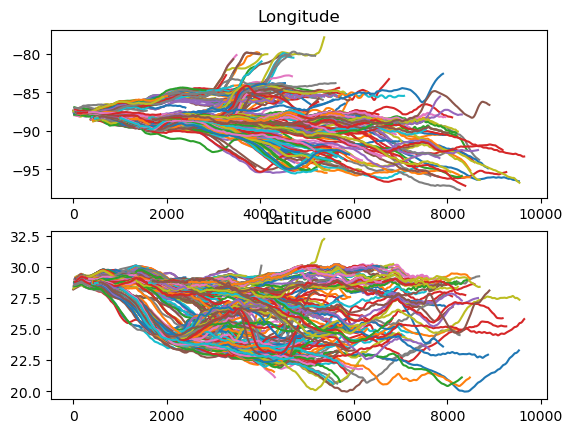

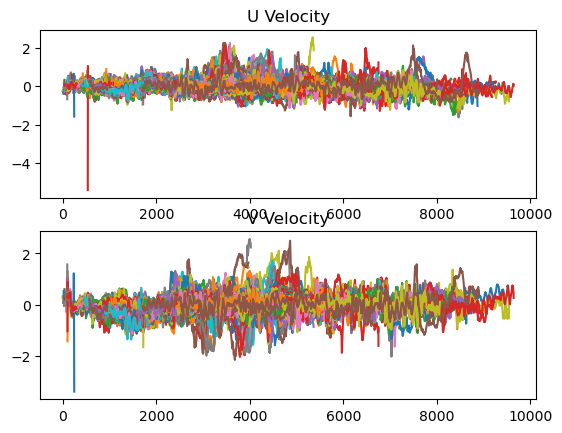

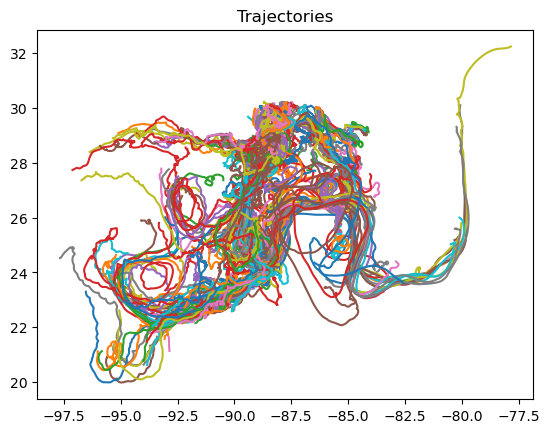

In [5]:
# LASER
T, X, Y, U, V = convert_drifter_struct_to_array(
    pkl_file_path='./traj_structs_LASER_15min_03_May_2021.pkl',     # the file created in step 1
    sel_data='LASER',                     # or 'GLAD' depending on dataset
    output_dir='./',                 # where to save the aligned trajectory data
    make_plots=True,                      # optional plotting
    max_workers=6                        # number of parallel processes
)

### Calculate the ocean depth at each points of the trajectory and add to data file.

Output is used later to keep data that is in deep waters.

In [6]:
# 

### Step 2: Estimate drifter depths using the downloaded Sandwell data

Estimating depths: 100%|███████████████| 297/297 [00:00<00:00, 5761.83it/s]


Saved trajectory depth matrix to traj_depth_GLAD.pkl


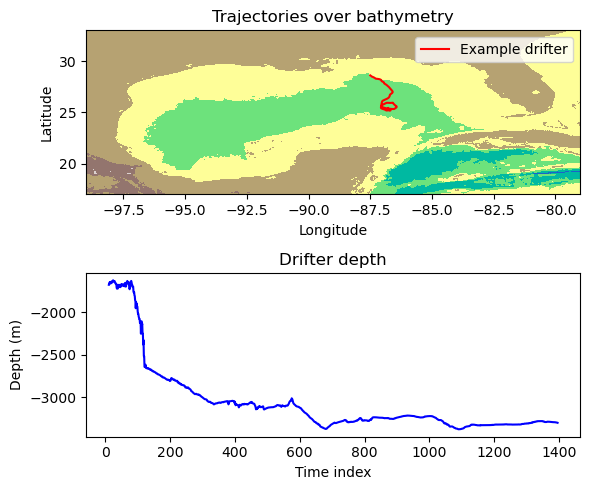

In [7]:
# GLAD
Hglad = estimate_drifter_depth(
    'traj_mat_GLAD_15min_04_May_2021.pkl',
    'traj_depth_GLAD.pkl',
    sandwell_nc_path='sandwell_topography.nc',
    make_plots=True
)

Estimating depths: 100%|███████████████| 956/956 [00:00<00:00, 6139.57it/s]


Saved trajectory depth matrix to traj_depth_LASER.pkl


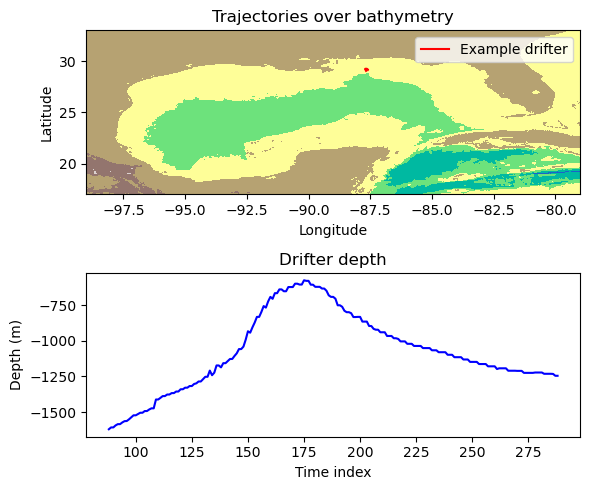

In [8]:
# LASER
Hlaser = estimate_drifter_depth(
    'traj_mat_LASER_15min_04_May_2021.pkl',
    'traj_depth_LASER.pkl',
    sandwell_nc_path='sandwell_topography.nc',
    make_plots=True
)

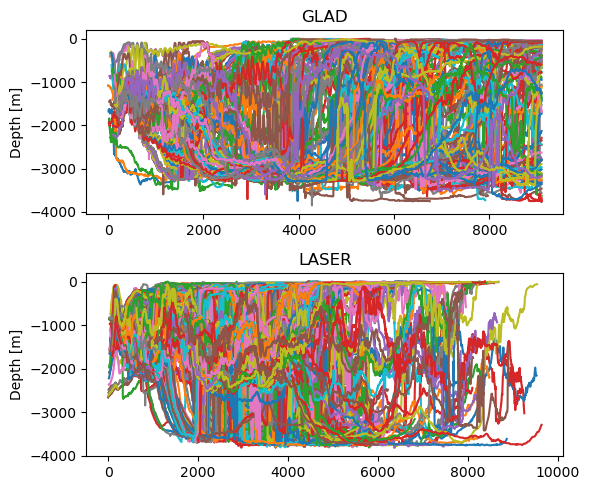

In [9]:
import pickle

# Load depth arrays
with open('traj_depth_LASER.pkl', 'rb') as f:
    Hlaser = pickle.load(f)

with open('traj_depth_GLAD.pkl', 'rb') as g:
    Hglad = pickle.load(g)

# Plot
fig0, ax = plt.subplots(2, 1, figsize=(6,5))

ax[0].plot(Hglad)       # just use the array directly
ax[0].set_title('GLAD')
ax[0].set_ylabel('Depth [m]')

ax[1].plot(Hlaser)      # just use the array directly
ax[1].set_title('LASER')
ax[1].set_ylabel('Depth [m]')

plt.tight_layout()
plt.show()

### Convert trajectories to binned pairs, and estimmates velocity fluctuations.

For each unique pair of drifters, velocity fluctuations are calculated as:

\begin{equation}
\delta \mathbf{u}(\mathbf{s},\mathbf{r}, t) = \mathbf{u}(\mathbf{s} + \mathbf{r}, t) - \mathbf{u}(\mathbf{s}, t),    
\end{equation}

To avoid reliance on fixed geographical coordinates, we decompose $\delta \mathbf{u}$ into longitudinal and transverse components $\mathbf{\delta u}=(\delta u_{L}, \delta u_{T})$:

\begin{equation}
    \delta u_{L}=\delta \mathbf{u}\cdot\frac{\mathbf{r}}{|\mathbf{r}|},\ \ \ \
    \delta u_{T}=\frac{\mathbf{\widehat{z}}\cdot(\delta \mathbf{u}\times \mathbf{r})}{|\mathbf{r}|},
\end{equation}

where $\mathbf{\widehat{\mathbf{z}}}$ is the vertical unit vector.

In [10]:
# GLAD
data_glad = compute_structure_pairs(
    'traj_mat_GLAD_15min_04_May_2021.pkl',
    'traj_depth_GLAD.pkl',
    'structure_pairs_GLAD.pkl',
    n_jobs=15
)

Processing pairs: 100%|████████████████| 9098/9098 [02:11<00:00, 69.24it/s]


In [11]:
# LASER
data_laser = compute_structure_pairs(
    'traj_mat_LASER_15min_04_May_2021.pkl',
    'traj_depth_LASER.pkl',
    'structure_pairs_LASER.pkl',
    n_jobs = 20
)

Processing pairs: 100%|████████████████| 9644/9644 [03:49<00:00, 42.01it/s]


In [12]:
# Check type
print(type(data_glad))

# If it's a list or NumPy array, get length or shape
if isinstance(data_glad, list):
    print(f'GLAD Length: {len(data_glad)}')
    print(f'GLAD Type of first element: {type(data_glad[0])}')
elif hasattr(data_glad, 'shape'):
    print(f'GLAD Shape: {data_glad.shape}')
else:
    print('Loaded object does not have a shape or length directly.')
    
# Check type
print(type(data_laser))

# If it's a list or NumPy array, get length or shape
if isinstance(data_laser, list):
    print(f'LASER Length: {len(data_laser)}')
    print(f'LASER Type of first element: {type(data_laser[0])}')
elif hasattr(data_laser, 'shape'):
    print(f'LASER Shape: {data_laser.shape}')
else:
    print('Loaded object does not have a shape or length directly.')

<class 'list'>
GLAD Length: 9098
GLAD Type of first element: <class 'dict'>
<class 'list'>
LASER Length: 9644
LASER Type of first element: <class 'dict'>


Text(0.5, 1.0, 'Drifter Pair')

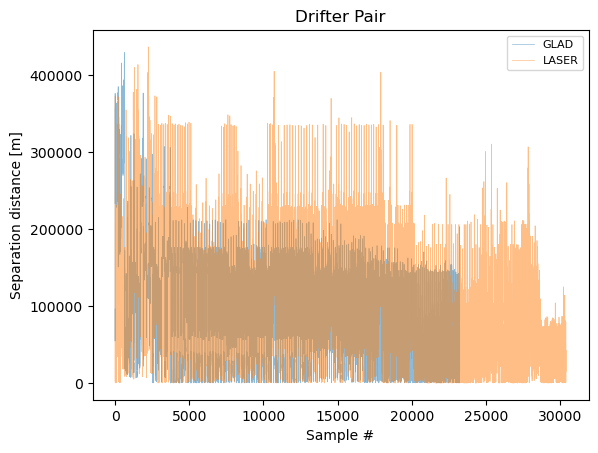

In [13]:
plt.plot(data_glad[1000]['dist'], linewidth=0.5, label='GLAD', alpha=0.5)
plt.plot(data_laser[1000]['dist'], linewidth=0.5, label='LASER', alpha=0.5)
plt.xlabel('Sample #')
plt.ylabel('Separation distance [m]')
plt.legend(fontsize=8)
plt.title('Drifter Pair')

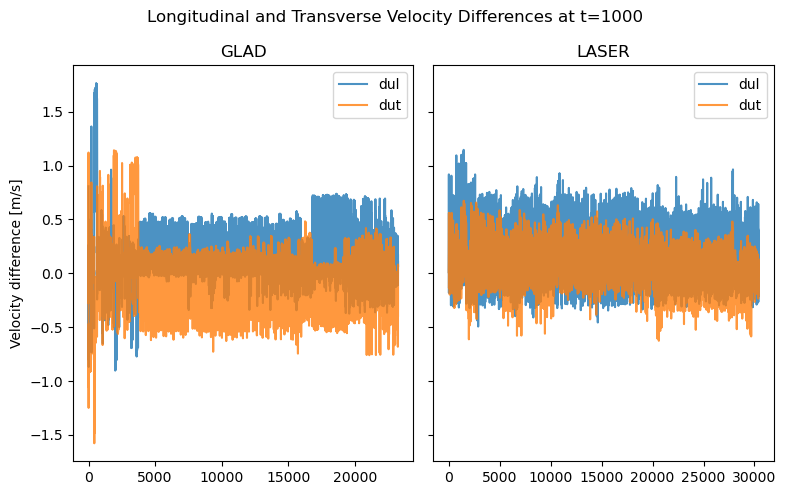

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

axes[0].plot(data_glad[1000]['dul'], label='dul', alpha=0.8)
axes[0].plot(data_glad[1000]['dut'], label='dut', alpha=0.8)
axes[0].set_title('GLAD')
axes[0].set_ylabel('Velocity difference [m/s]')
axes[0].legend()

axes[1].plot(data_laser[1000]['dul'], label='dul', alpha=0.8)
axes[1].plot(data_laser[1000]['dut'], label='dut', alpha=0.8)
axes[1].set_title('LASER')
axes[1].legend()

fig.suptitle('Longitudinal and Transverse Velocity Differences at t=1000')
plt.tight_layout()
plt.show()

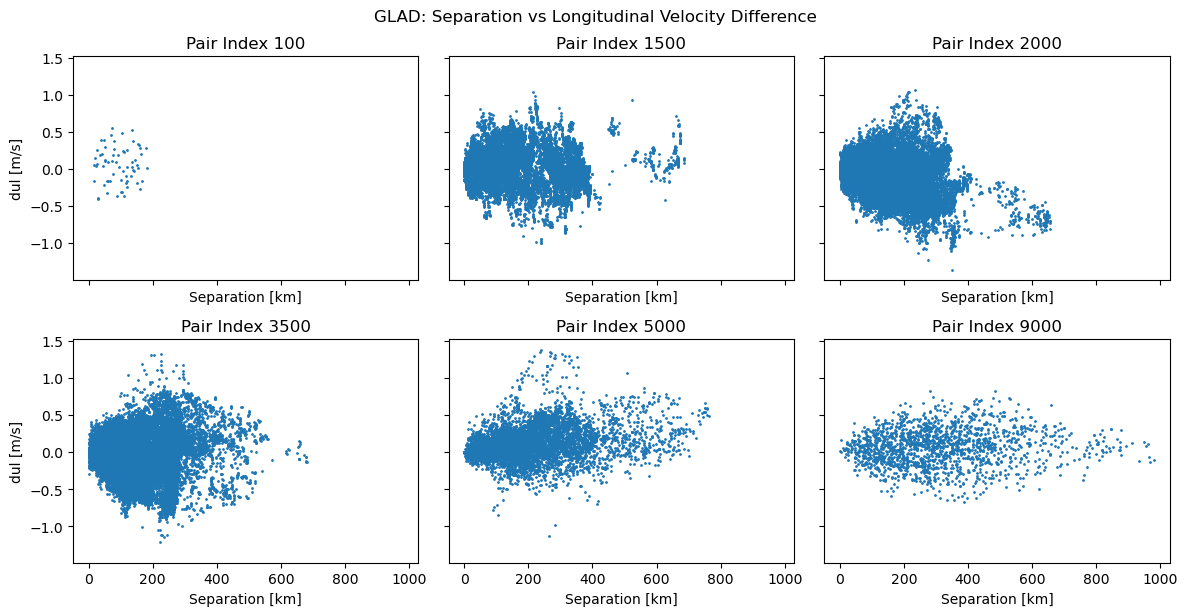

In [15]:
# Indices you want to plot
indices = [100, 1500, 2000, 3500, 5000, 9000]

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
axs = axs.flatten()  # Flatten to easily index with a single loop

for i, idx in enumerate(indices):
    axs[i].plot(data_glad[idx]['dist']*1e-3, data_glad[idx]['dul'], '.', markersize=2)
    axs[i].set_title(f'Pair Index {idx}')
    axs[i].set_xscale('linear')
    axs[i].set_xlabel('Separation [km]')
    if i % 3 == 0:
        axs[i].set_ylabel('dul [m/s]')

plt.tight_layout()
plt.suptitle('GLAD: Separation vs Longitudinal Velocity Difference', y=1.02)
plt.show()

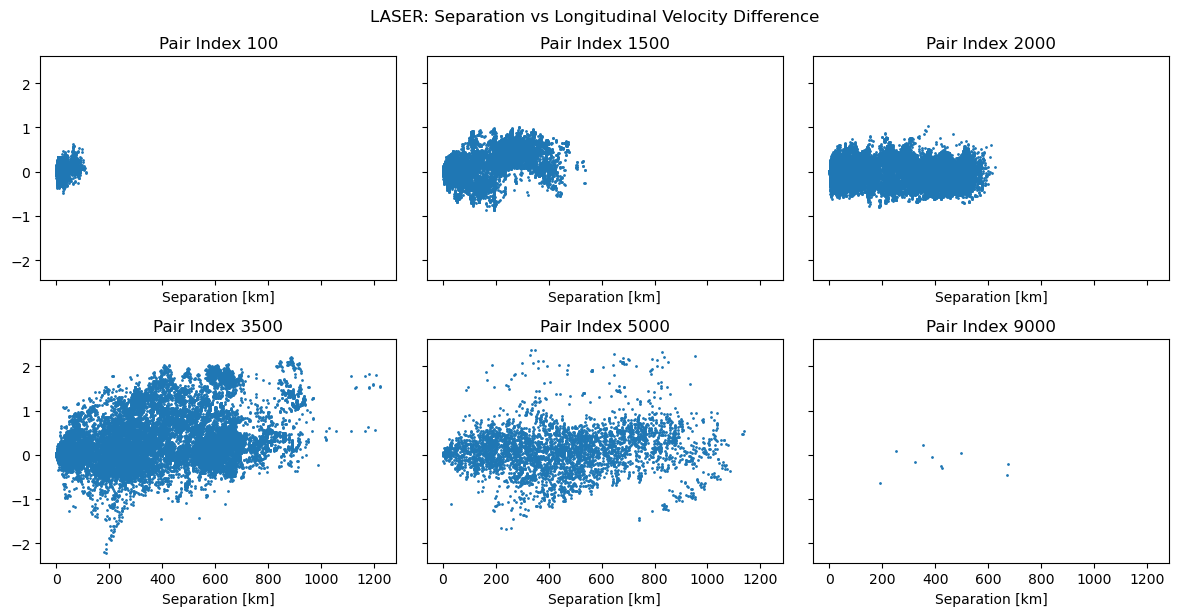

In [16]:
# Indices you want to plot
indices = [100, 1500, 2000, 3500, 5000, 9000]

fig0, axs0 = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
axs0 = axs0.flatten()  # Flatten to easily index with a single loop

for i, idx in enumerate(indices):
    axs0[i].plot(data_laser[idx]['dist']*1e-3, data_laser[idx]['dul'], '.', markersize=2)
    axs0[i].set_title(f'Pair Index {idx}')
    axs0[i].set_xscale('linear')
    axs0[i].set_xlabel('Separation [km]')
    if i % 3 == 0:
        axs[i].set_ylabel('dul [m/s]')

plt.tight_layout()
plt.suptitle('LASER: Separation vs Longitudinal Velocity Difference', y=1.02)
plt.show()

### Bins the velocity differences into $r$ bins

In [54]:
# For log-spaced 

gamma = 1.5
dist_bin_log = np.array([10 * gamma**i for i in range(100)])
dist_bin_log = dist_bin_log[dist_bin_log <= 1e6]  # up to 1000 km
dist_bin_log = np.insert(dist_bin_log, 0, 0)

Binning pairs: 100%|███████████████████████| 29/29 [00:19<00:00,  1.45it/s]


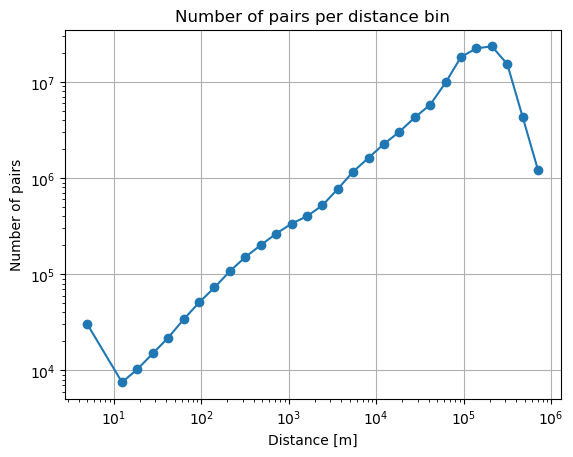

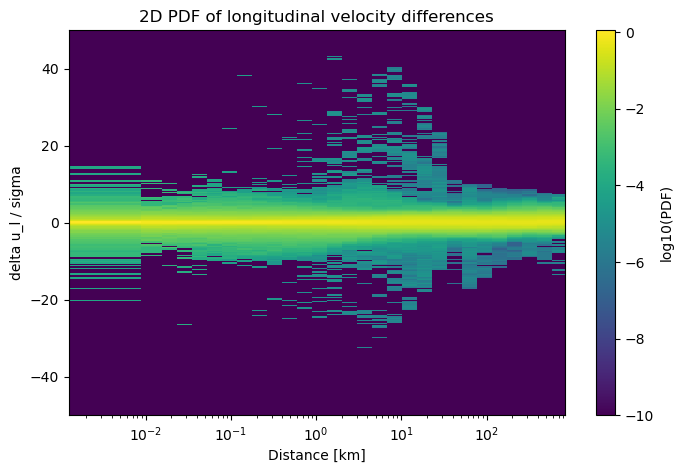

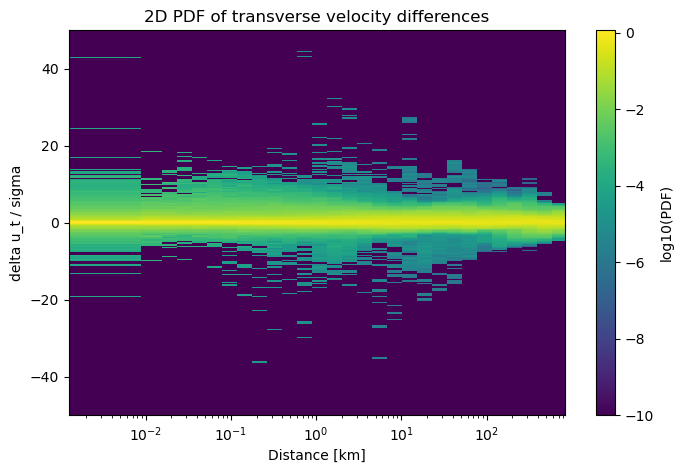

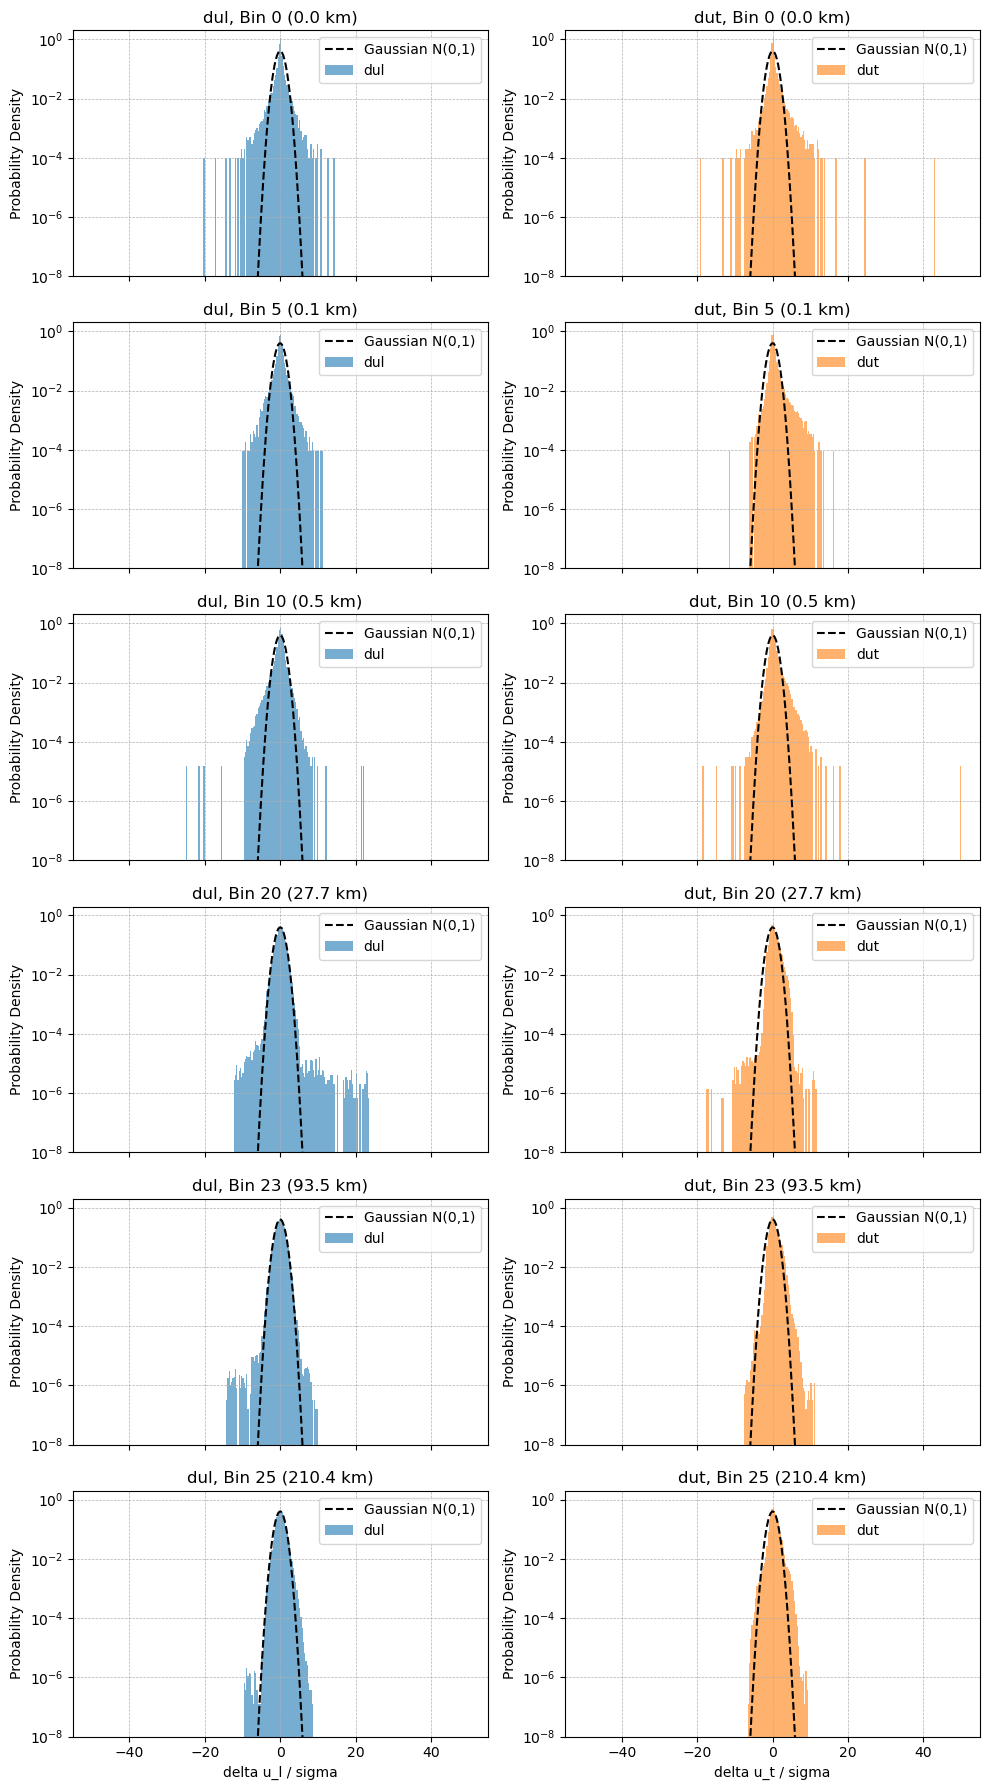

In [55]:
# GLAD
GLAD = save_binned_velocity_differences('structure_pairs_GLAD.pkl', 
                                        'pairs_sep_GLAD.pkl',
                                        dist_bin_log,
                                        plot=True, 
                                        plot_bins=[0, 5, 10, 20, 23, 25])

Binning pairs: 100%|███████████████████████| 29/29 [00:08<00:00,  3.43it/s]


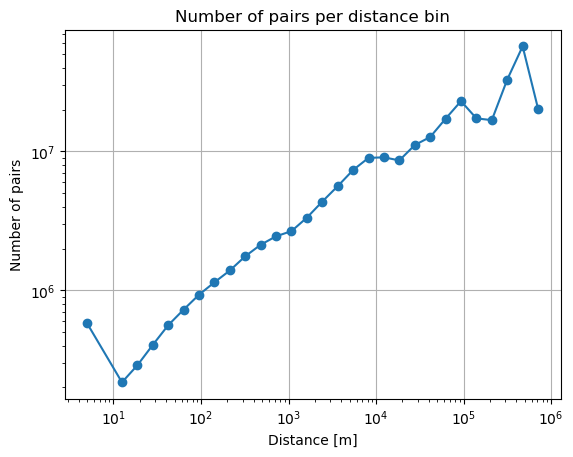

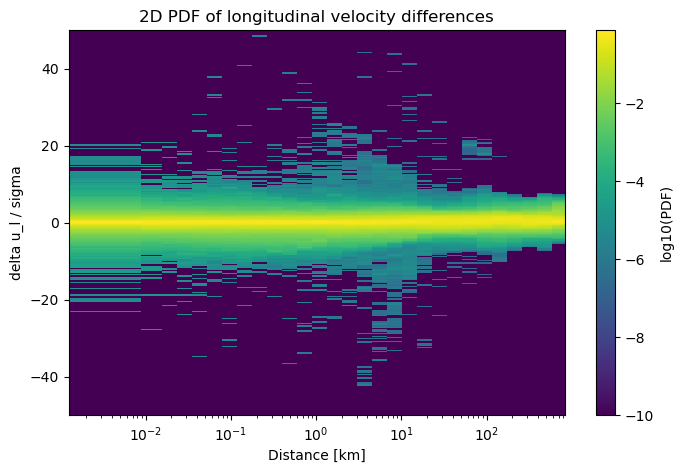

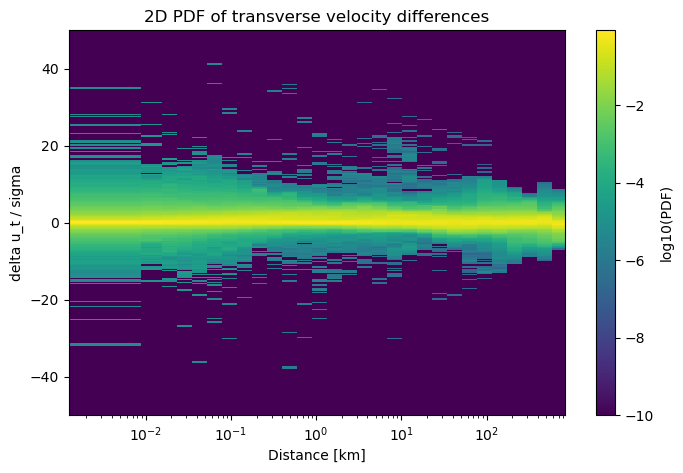

Binning pairs:   9%|█▏           | 911/9999 [23:55:19<238:38:37, 94.53s/it]


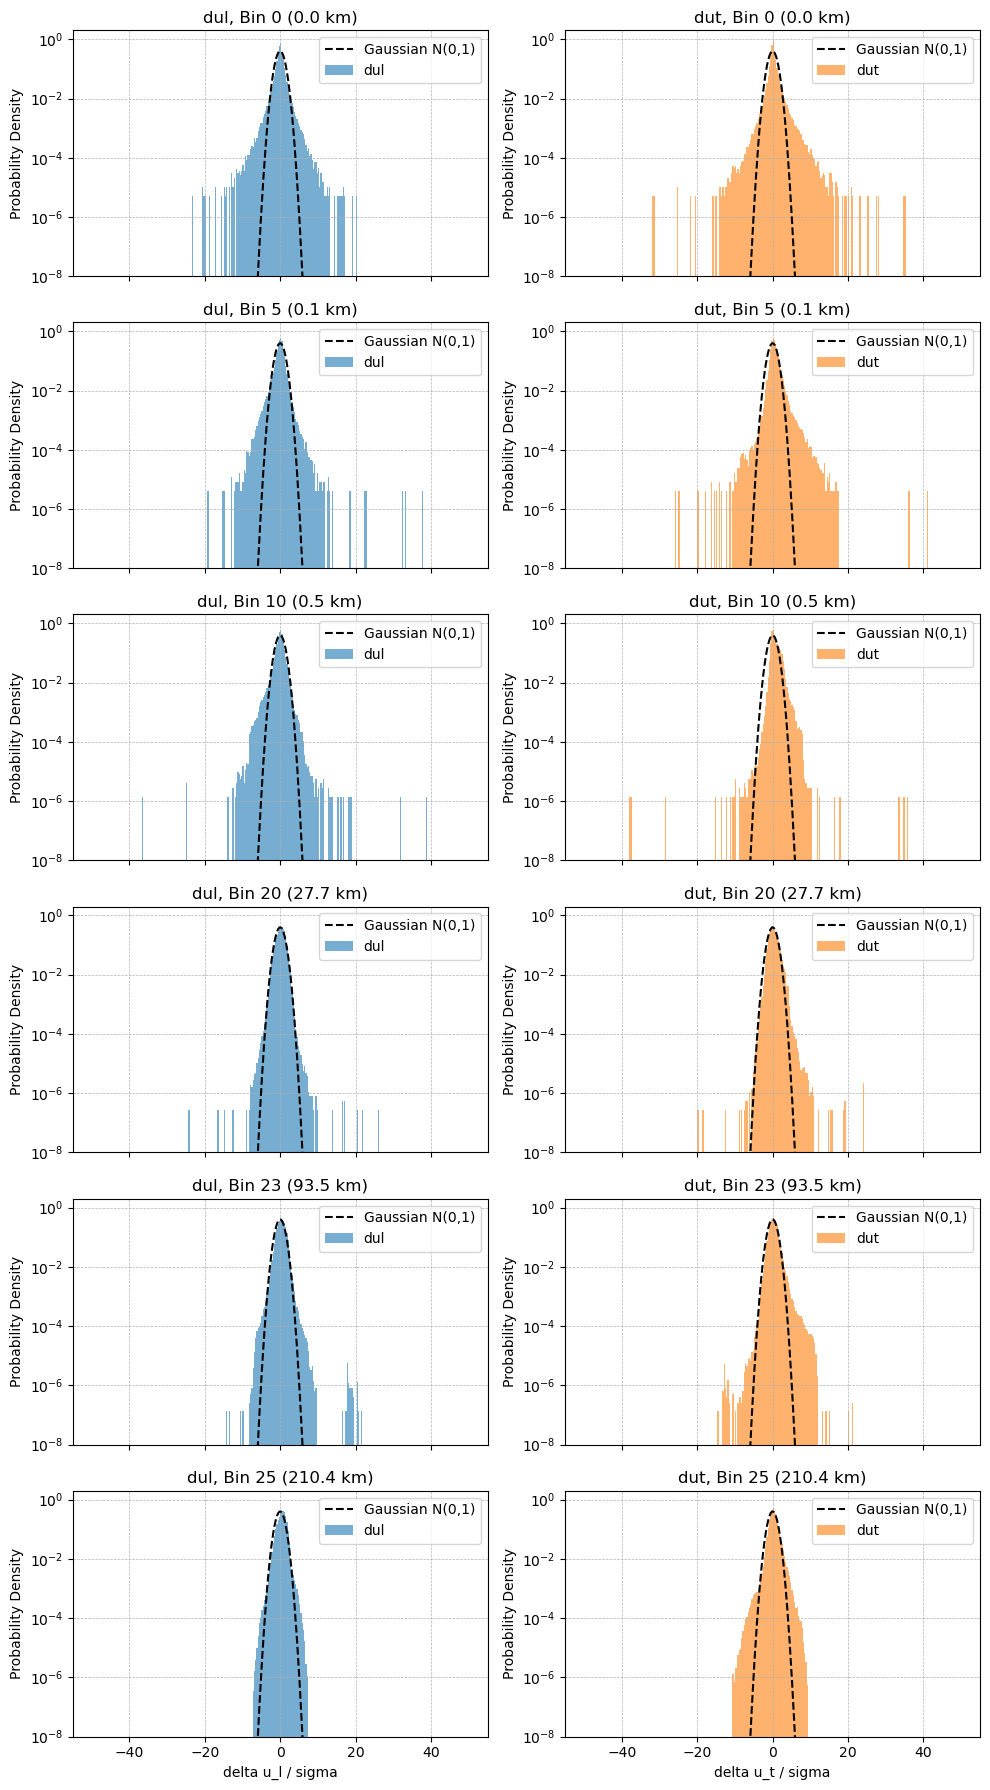

In [56]:
# LASER
LASER = save_binned_velocity_differences('structure_pairs_LASER.pkl', 
                                          'pairs_sep_LASER.pkl',
                                          dist_bin_log,
                                          plot=True, 
                                          plot_bins=[0, 5, 10, 20, 23, 25])

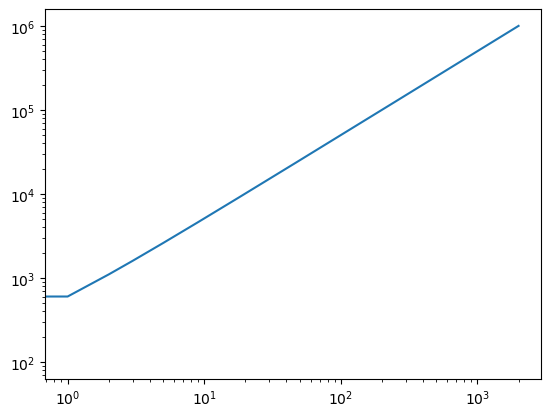

In [57]:
# linearly spaced bins
dr = 5e2
dist_bin_lin = np.arange(1e2, 1e6 + dr, dr)
plt.loglog(dist_bin_lin)

Binning pairs: 100%|███████████████████| 2000/2000 [04:41<00:00,  7.11it/s]


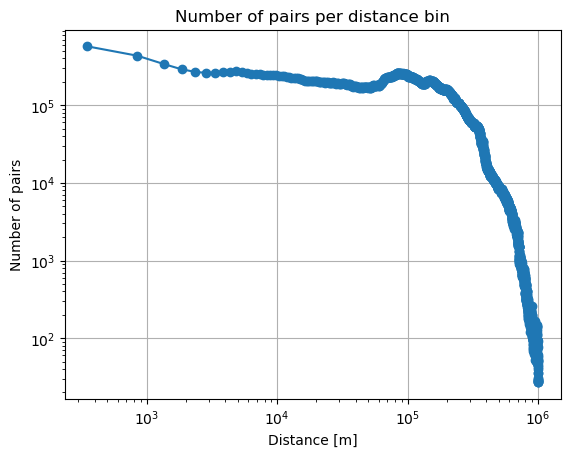

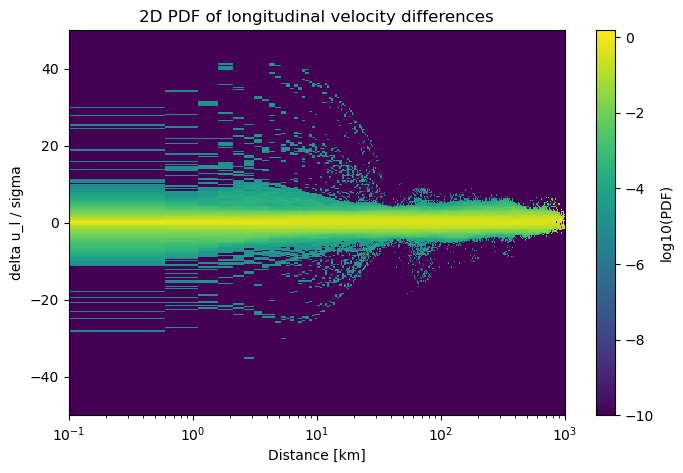

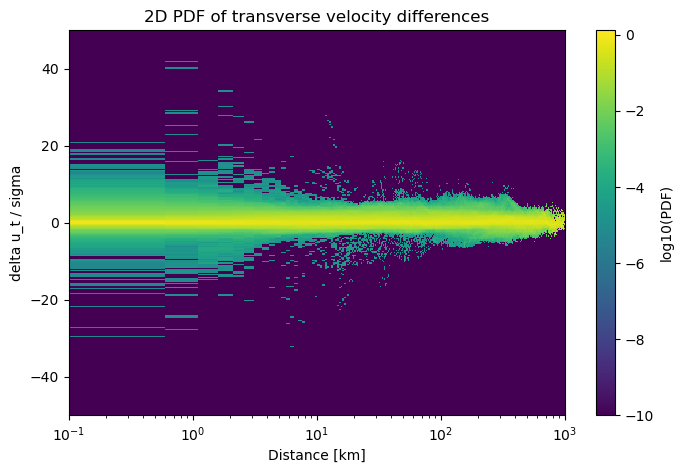

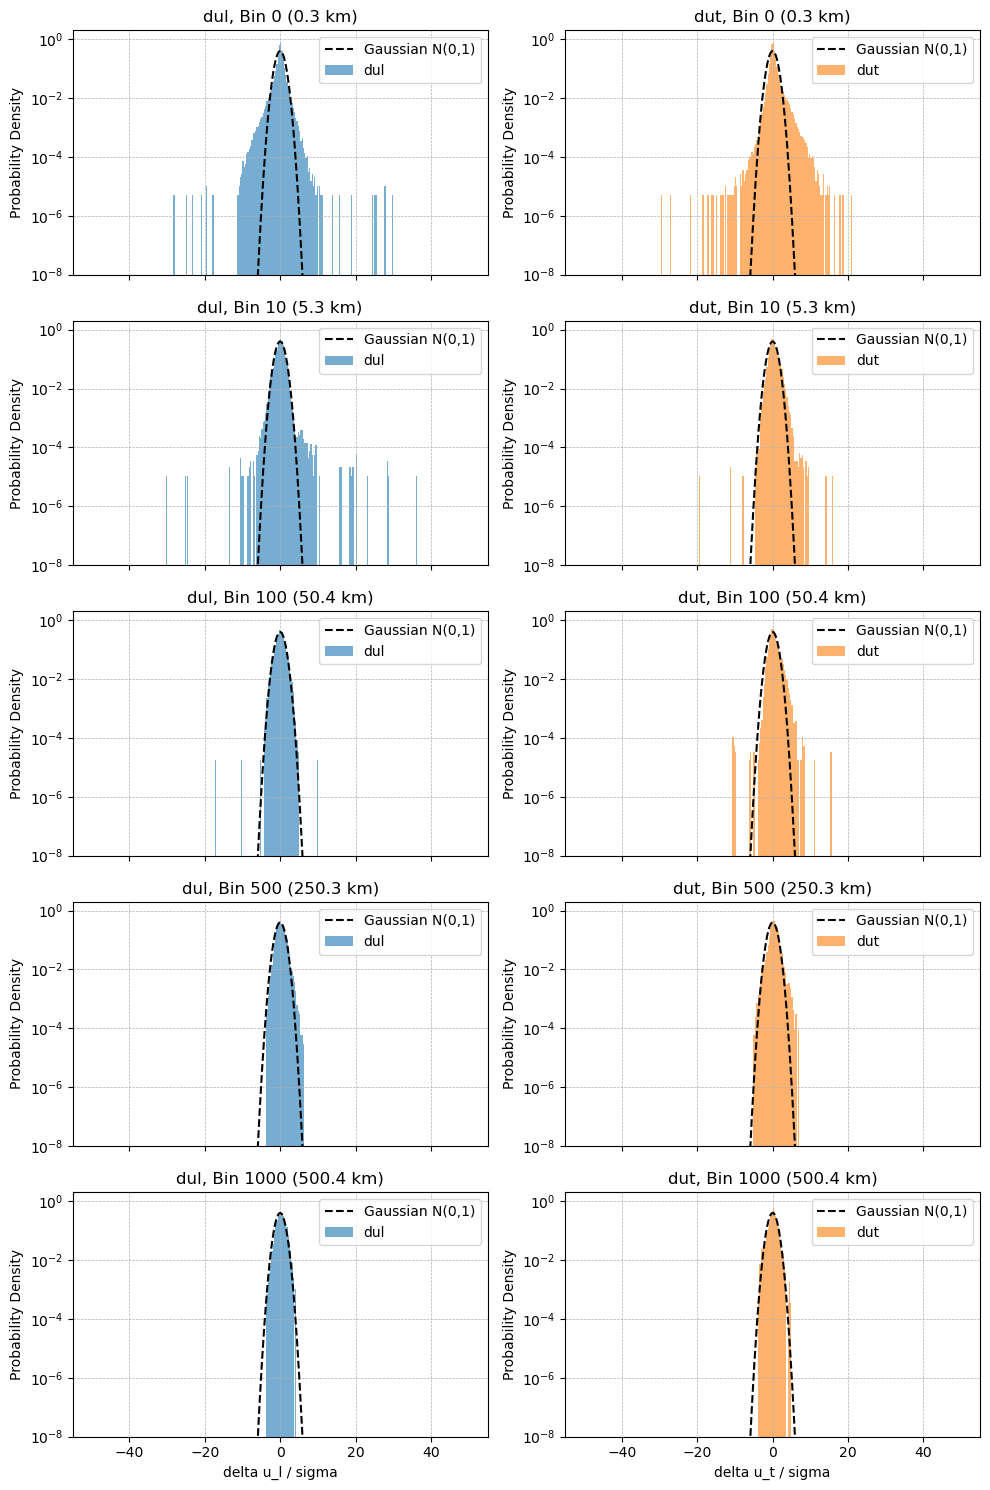

In [58]:
# GLAD (linear spaced bins)
GLAD_lin = save_binned_velocity_differences('structure_pairs_GLAD.pkl', 
                                            'pairs_sep_GLAD_linR.pkl',
                                            dist_bin_lin,
                                            plot=True,
                                            plot_bins=[0, 10, 100, 500, 1000],
                                            n_jobs=20)

Binning pairs: 100%|███████████████████| 2000/2000 [04:05<00:00,  8.15it/s]


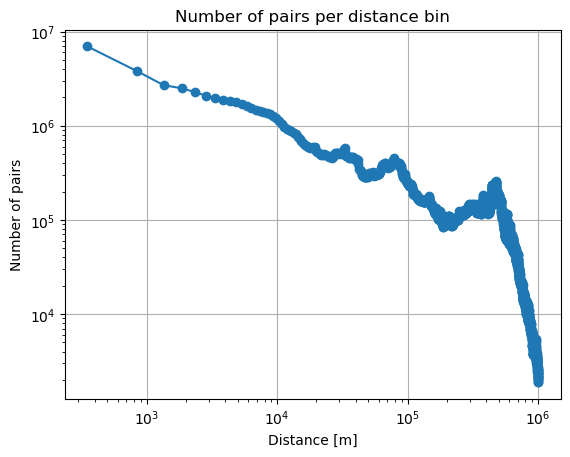

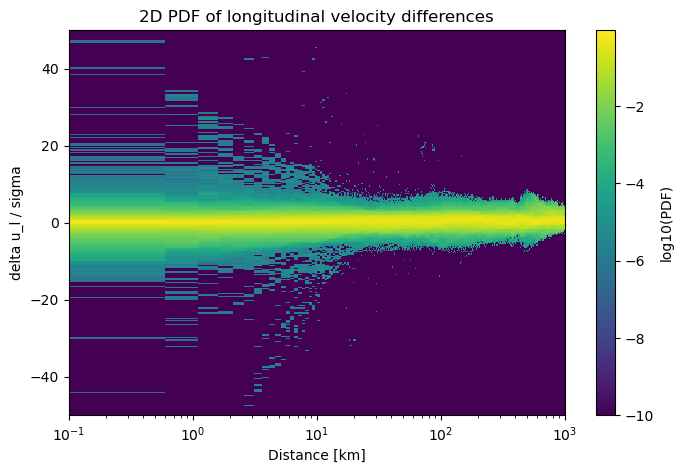

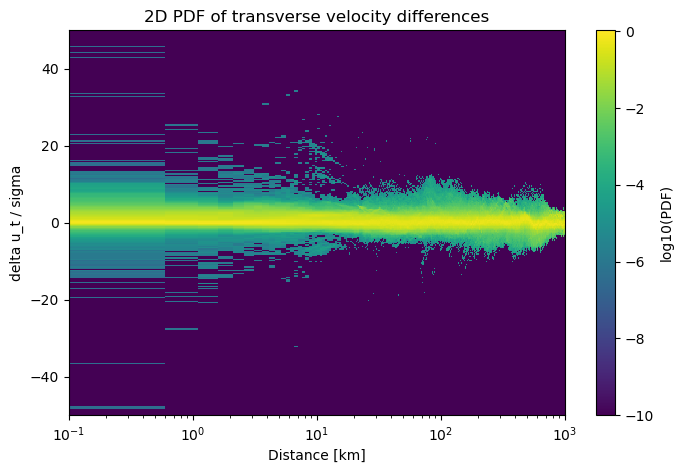

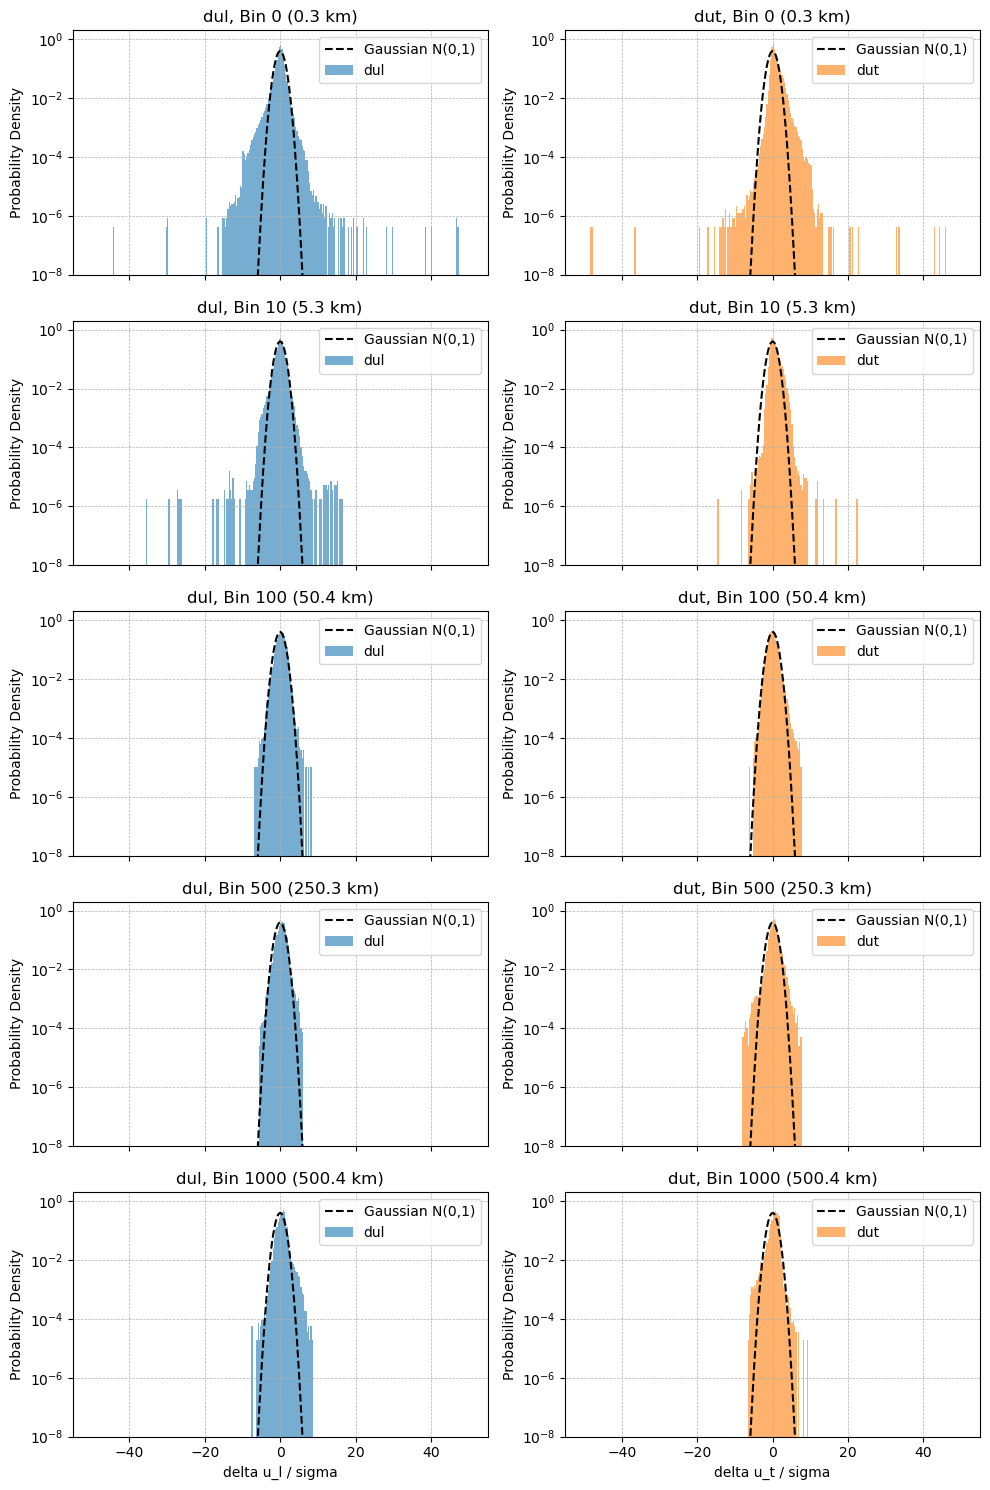

In [59]:
# LASER (linearly spaced bins)
LASER_lin = save_binned_velocity_differences('structure_pairs_LASER.pkl', 
                                             'pairs_sep_LASER_linR.pkl',
                                             dist_bin_lin,
                                             plot=True, 
                                             plot_bins=[0, 10, 100, 500, 1000],
                                             n_jobs=20)

In [2]:
# Load GLAD pairs_sep
with open('./pairs_sep_GLAD_linR.pkl', 'rb') as f:
    glad_lin = pickle.load(f)

glad_dul_lin = glad_lin['dul']
glad_dut_lin = glad_lin['dut']
dist_all_lin = glad_lin['dist_axis']

# Load LASER pairs_sep
with open('./pairs_sep_LASER_linR.pkl', 'rb') as f:
    laser_lin = pickle.load(f)

laser_dul_lin = laser_lin['dul']
laser_dut_lin = laser_lin['dut']

In [3]:
# Define number of CPU cores for parallelism
import StrucFunction
importlib.reload(StrucFunction)
from StrucFunction import *

import structfunc2KEflux
importlib.reload(structfunc2KEflux)
from structfunc2KEflux import *

from scipy.stats import kurtosis, skew
from joblib import Parallel, delayed  # For parallel processing

# Function to calculate the necessary statistics
def calculate_SF_stats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser):
    glad_stats = {
        'mean': np.mean(du_glad),
        'std': np.std(du_glad),
        'skew': skew(du_glad),
        'kurt': kurtosis(du_glad, fisher=True)
    }
    
    laser_stats = {
        'mean': np.mean(du_laser),
        'std': np.std(du_laser),
        'skew': skew(du_laser),
        'kurt': kurtosis(du_laser, fisher=True)
    }

    glad_du2_stats = {
        'mean': np.mean(du2_glad),
        'std': np.std(du2_glad),
        'skew': skew(du2_glad),
        'kurt': kurtosis(du2_glad, fisher=True)
    }

    laser_du2_stats = {
        'mean': np.mean(du2_laser),
        'std': np.std(du2_laser),
        'skew': skew(du2_laser),
        'kurt': kurtosis(du2_laser, fisher=True)
    }

    glad_du3_stats = {
        'mean': np.mean(du3_glad),
        'std': np.std(du3_glad),
        'skew': skew(du3_glad),
        'kurt': kurtosis(du3_glad, fisher=True)
    }

    laser_du3_stats = {
        'mean': np.mean(du3_laser),
        'std': np.std(du3_laser),
        'skew': skew(du3_laser),
        'kurt': kurtosis(du3_laser, fisher=True)
    }

    return glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats


# Parallelize the processing of each index
def calcSF23_stats(ii, glad_dul, glad_dut, laser_dul, laser_dut):
    """
    Calculate structure function statistics for a single index `ii`
    using provided datasets for glad and laser experiments.
    """
    # Compute total velocity differences
    du_glad = glad_dul[ii] + glad_dut[ii]
    du_laser = laser_dul[ii] + laser_dut[ii]
    
    # Compute 2nd and 3rd order structure functions
    du2_glad, du3_glad = SF2_3(glad_dul[ii], glad_dut[ii])
    du2_laser, du3_laser = SF2_3(laser_dul[ii], laser_dut[ii])

    # Return statistics
    return calculate_SF_stats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser)

In [9]:
# Estimate statistics
num_cores = 6  # use all available cores
results = Parallel(n_jobs=num_cores, backend="threading")(
    delayed(calcSF23_stats)(ii, glad_dul_lin, glad_dut_lin, laser_dul_lin, laser_dut_lin)
    for ii in tqdm(range(len(dist_all_lin)))
)

# Convert results to structured NumPy arrays in one go
results = list(zip(*results))  # unzip once
glad_stats_lin, laser_stats_lin, glad_du2_stats_lin, laser_du2_stats_lin, glad_du3_stats_lin, laser_du3_stats_lin = results

def stack_stats(stats_list):
    """Convert list of dicts to stacked arrays: mean, std, skew, kurt"""
    return np.stack([s['mean'] for s in stats_list]), \
           np.stack([s['std'] for s in stats_list]), \
           np.stack([s['skew'] for s in stats_list]), \
           np.stack([s['kurt'] for s in stats_list])

# Extract all 
glad_du_mean_lin, glad_du_std_lin, glad_du_skew_lin, glad_du_kurt_lin = stack_stats(glad_stats_lin)
laser_du_mean_lin, laser_du_std_lin, laser_du_skew_lin, laser_du_kurt_lin = stack_stats(laser_stats_lin)

glad_du2_mean_lin, glad_du2_std_lin, glad_du2_skew_lin, glad_du2_kurt_lin = stack_stats(glad_du2_stats_lin)
laser_du2_mean_lin, laser_du2_std_lin, laser_du2_skew_lin, laser_du2_kurt_lin = stack_stats(laser_du2_stats_lin)

glad_du3_mean_lin, glad_du3_std_lin, glad_du3_skew_lin, glad_du3_kurt_lin = stack_stats(glad_du3_stats_lin)
laser_du3_mean_lin, laser_du3_std_lin, laser_du3_skew_lin, laser_du3_kurt_lin = stack_stats(laser_du3_stats_lin)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
# Load GLAD pairs_sep log-spaced
with open('./pairs_sep_GLAD.pkl', 'rb') as f:
    glad = pickle.load(f)

glad_dul_log = glad['dul']
glad_dut_log = glad['dut']
dist_all_log = glad['dist_axis']

# Load LASER pairs_sep
with open('./pairs_sep_LASER.pkl', 'rb') as f:
    laser = pickle.load(f)

laser_dul_log = laser['dul']
laser_dut_log = laser['dut']

In [10]:
# Estimate statistics
num_cores = 6  # use all available cores
results = Parallel(n_jobs=num_cores, backend="threading")(
    delayed(calcSF23_stats)(ii, glad_dul_log, glad_dut_log, laser_dul_log, laser_dut_log)
    for ii in tqdm(range(len(dist_all_log)))
)

# Convert results to structured NumPy arrays in one go
results = list(zip(*results))  # unzip once
glad_stats_log, laser_stats_log, glad_du2_stats_log, laser_du2_stats_log, glad_du3_stats_log, laser_du3_stats_log = results

def stack_stats(stats_list):
    """Convert list of dicts to stacked arrays: mean, std, skew, kurt"""
    return np.stack([s['mean'] for s in stats_list]), \
           np.stack([s['std'] for s in stats_list]), \
           np.stack([s['skew'] for s in stats_list]), \
           np.stack([s['kurt'] for s in stats_list])

# Extract all 
glad_du_mean_log, glad_du_std_log, glad_du_skew_log, glad_du_kurt_log = stack_stats(glad_stats_log)
laser_du_mean_log, laser_du_std_log, laser_du_skew_log, laser_du_kurt_log = stack_stats(laser_stats_log)

glad_du2_mean_log, glad_du2_std_log, glad_du2_skew_log, glad_du2_kurt_log = stack_stats(glad_du2_stats_log)
laser_du2_mean_log, laser_du2_std_log, laser_du2_skew_log, laser_du2_kurt_log = stack_stats(laser_du2_stats_log)

glad_du3_mean_log, glad_du3_std_log, glad_du3_skew_log, glad_du3_kurt_log = stack_stats(glad_du3_stats_log)
laser_du3_mean_log, laser_du3_std_log, laser_du3_skew_log, laser_du3_kurt_log = stack_stats(laser_du3_stats_log)

  0%|          | 0/29 [00:00<?, ?it/s]

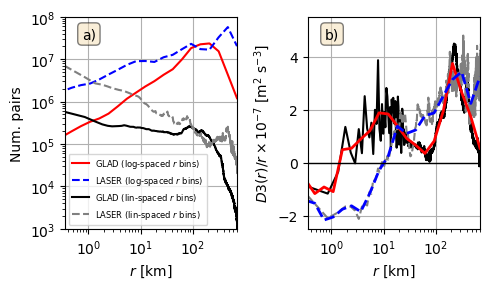

In [42]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig = plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.loglog(dist_all_log*1e-3, glad['n_pairs'], '-', 
           color='red', label='GLAD (log-spaced $r$ bins)')
plt.loglog(dist_all_log*1e-3, laser['n_pairs'], '--', 
           color='blue', label='LASER (log-spaced $r$ bins)')
plt.loglog(dist_all_lin*1e-3, glad_lin['n_pairs'], '-', 
           color='black', label='GLAD (lin-spaced $r$ bins)')
plt.loglog(dist_all_lin*1e-3, laser_lin['n_pairs'], '--', 
           color='gray', label='LASER (lin-spaced $r$ bins)')
plt.xlim(dist_all_lin.min()*1e-3, dist_all_log.max()*1e-3)
plt.grid()
plt.xlabel('$r$ [km]')
plt.ylabel('Num. pairs')
plt.ylim(1e3, 1e8)
plt.text(0.1, 0.90, 'a)', bbox=props, transform=plt.gca().transAxes)
plt.legend(fontsize=6)

plt.subplot(1, 2, 2)
plt.semilogx(dist_all_lin*1e-3, glad_du3_mean_lin/dist_all_lin * 1e7, '-', 
             color='black', label='GLAD (linearly-spaced $r$ bins)')
plt.semilogx(dist_all_lin*1e-3, laser_du3_mean_lin/dist_all_lin * 1e7, '--',
             color='gray', label='LASER (linearly-spaced $r$ bins)')
plt.semilogx(dist_all_log*1e-3, glad_du3_mean_log/dist_all_log * 1e7, '-r', 
             linewidth=2, label='GLAD (log-spaced $r$ bins)')
plt.semilogx(dist_all_log*1e-3, laser_du3_mean_log/dist_all_log * 1e7, '--b', 
             linewidth=2, label='LASER (log-spaced $r$ bins)')
plt.axhline(0, linestyle='-', color='black', linewidth=1)
plt.xlim(dist_all_lin.min()*1e-3, dist_all_log.max()*1e-3)
plt.grid()
plt.xlabel('$r$ [km]')
plt.ylabel('$D3(r)/r \\times 10^{-7}$ [m$^2$ s$^{-3}$]')
plt.text(0.1, 0.90, 'b)', bbox=props, transform=plt.gca().transAxes)
plt.ylim(-2.5, 5.5)

plt.tight_layout()
fig.savefig('./FiguresMethodsPaper/fig_drif_response.png', bbox_inches = 'tight', format='png', dpi=500)